# Building, optimizing and evaluating machine learning models

In [4]:
import math
import numpy as np
import os
import cv2
import gc

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

## Machine learning models

### Super Vector Machine

In [5]:
def evaluate_svm(X, y, svm_C = 100):
    svm = SVC(kernel="rbf", C=svm_C)
    svm_scores = cross_val_score(svm, X, y, cv=5)
    svm_accuracy = np.average(svm_scores)
    return svm_scores, svm_accuracy

### Random Forest

In [6]:
def evaluate_random_forest(X,y):
    rand_f = RandomForestClassifier()
    rand_f_scores = cross_val_score(rand_f, X, y, cv=5)
    rand_f_accuracy = np.average(rand_f_scores)
    
    return rand_f_scores, rand_f_accuracy

### Logistic Regression

In [7]:
def evaluate_logistic_regression(X, y):
    logr = LogisticRegression(solver='lbfgs', max_iter=100000)
    logr_scores = cross_val_score(logr, X, y, cv=5)
    logr_accuracy = np.average(logr_scores)
    return logr_scores, logr_accuracy

## Load and prepare data 

## Load and prepare data 

 Modify the `path` variable to point to the dataset
 
 The expected structure of the folder is: 
 ```
dataset-root:
    - *.jpg // full data set of images in forma jpg, those images with masks sould have the prefix `masks` in the name and those without masks shoudl have the prefix `faces`
    - anomalies  // folder with pictures considered anomalies to the main data set

 ```

In [8]:
path = 'colab/'

Applies the feature function to all the images Parameters

In [28]:
def get_data(feature_func, light_run = False, *feature_arg):
    """
    feature_func : func
        function to extract the features of the images
    Returns
    -------
    tuple
        data_set: np array , y_labeled: np array
    """
    image_names = os.listdir(path)
    data_set = []
    y_labeled = []
    prefix = 'faces'
    n_sample = len(image_names)
    
    if light_run:
        faces = [a for a in image_names if a.startswith(prefix)]
        masks = [a for a in image_names if not a.startswith(prefix)]
        image_names = faces[:500] + masks[:500]

    for name in image_names:
        if os.path.isdir(path+name): continue
        img = feature_func(name, *feature_arg)
        data_set.append(img.flatten())
        y_labeled.append(0 if name.startswith(prefix) else 1)
    data_set = np.array(data_set, dtype=np.int8)
    y_labeled = np.array(y_labeled, dtype=np.int8)
    print("Data prepared")
    return data_set, y_labeled

In [10]:
def load_image(image_name):
    original_image = cv2.imread(path + image_name, cv2.IMREAD_COLOR)
    return cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)

## Feature extraction

In [11]:
def clean_up(data_set, y_labeled):
    del data_set
    del y_labeled
    gc.collect()

In [12]:
def plot_images(original, transformed=np.array([]), label_2='', label_1 = 'Original Image'):
    figure_size = 12
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1),plt.imshow(original)
    plt.title(label_1), plt.xticks([]), plt.yticks([])
    if transformed.any():
        plt.subplot(1,2,2),plt.imshow(transformed)
        plt.title(label_2), plt.xticks([]), plt.yticks([])
    plt.show()

### Raw data

In [13]:
def raw_feature(name):
    return cv2.imread(path + name, cv2.IMREAD_COLOR)

### K-means clustering

In [14]:
attempts=10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

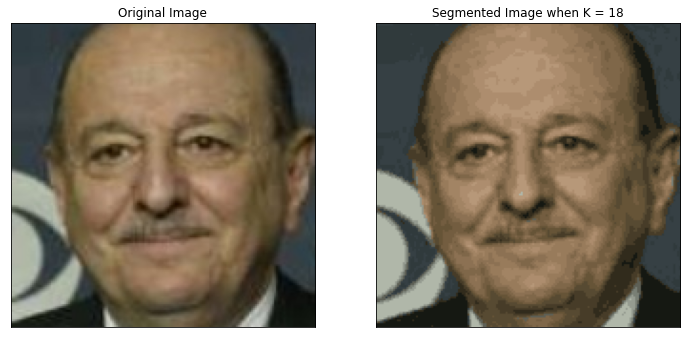

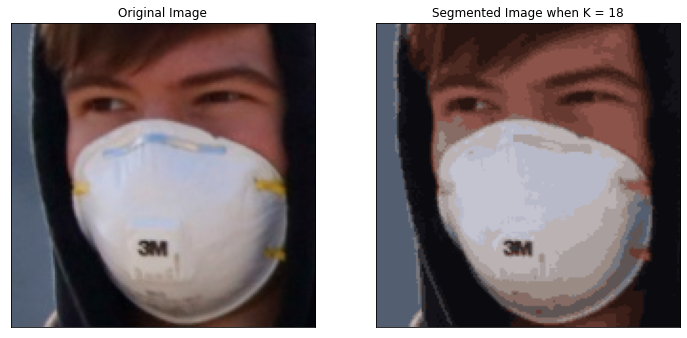

In [15]:
def kmeans_feature(image_name, print_result=False, K = 18):
    img = load_image(image_name)
    vector = np.float32(img.reshape((-1,3)))
    compactness,label,center=cv2.kmeans(vector,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    result = center[label.flatten()]
    result_image = result.reshape((img.shape))
    if print_result:
        plot_images(img,result_image, 'Segmented Image when K = %i' % K)

    return result_image

_ = kmeans_feature('faces12.jpg', True)
_ = kmeans_feature('masks153.jpg', True)

### Histogram of Oriented Gradients

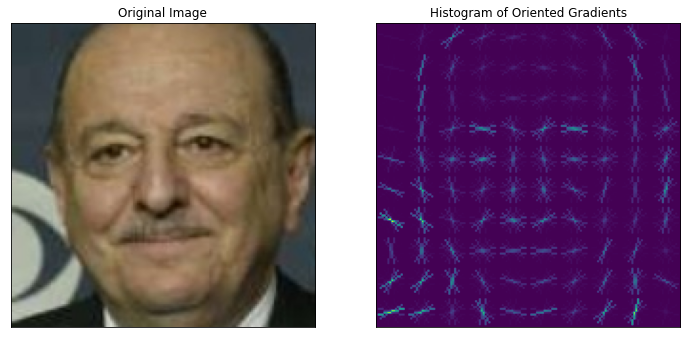

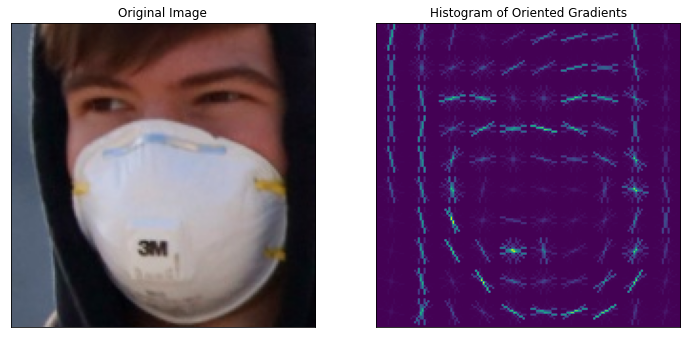

In [16]:
def hoc_feature(image_name, print_result=False):
    image = load_image(image_name)
    _, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=True, multichannel=True)
    
    if print_result:
        plot_images(image, hog_image, 'Histogram of Oriented Gradients')

    return hog_image

_ = hoc_feature('faces12.jpg', True)
_ = hoc_feature('masks153.jpg', True)

## Feature and Models optimization

In [19]:
def svm_optimization():
    candidate_smv_c = [1e-2, 1e-1, 1, 1e1, 1e2]
    X, y = get_data(hoc_feature, True)
    best_c = None
    best_performance = 0
    for candidate_C in candidate_smv_c:
        _, score = evaluate_svm(X, y, candidate_C)
        print("Score {} with {}".format(score, candidate_C))
        if best_performance < score:
            best_performance = score
            best_c = candidate_C
    clean_up(X,y)
    return best_c

svm_optimization()

Data prepared
Score 0.85 with 0.01
Score 0.9189999999999999 with 0.1
Score 0.9570000000000001 with 1
Score 0.95 with 10.0
Score 0.95 with 100.0


1

In [20]:
def k_means_optimization():
    candidates_k = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    best_k = None
    best_performance = 0
    for candidate_k in candidates_k:
        X, y = get_data(kmeans_feature, True, False, candidate_k)
        _, score = evaluate_random_forest(X, y)
        print("Score {} with K = {}".format(score, candidate_k))
        if best_performance < score:
            best_performance = score
            best_k = candidate_k
        clean_up(X,y)
    return best_k

k_means_optimization()

Data prepared
Score 0.865 with K = 2
Data prepared
Score 0.907 with K = 4
Data prepared
Score 0.9030000000000001 with K = 6
Data prepared
Score 0.893 with K = 8
Data prepared
Score 0.9030000000000001 with K = 10
Data prepared
Score 0.908 with K = 12
Data prepared
Score 0.899 with K = 14
Data prepared
Score 0.915 with K = 16
Data prepared
Score 0.9170000000000001 with K = 18
Data prepared
Score 0.906 with K = 20


18

## Features and Models evaluation

Data prepared
Data prepared
Data prepared


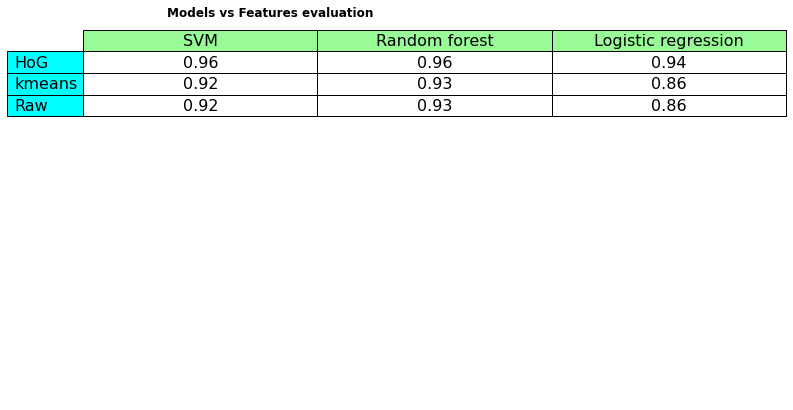

In [18]:
def evaluate_models():
    features = { "HoG": hoc_feature, "kmeans": kmeans_feature, "Raw": raw_feature}
    models = {"SVM": evaluate_svm, "Random forest": evaluate_random_forest, "Logistic regression": evaluate_logistic_regression}
    results = [ [0 for _ in models ] for _ in features]
    for i, feature_name in enumerate(list(features.keys())):        
        X, y = get_data(features[feature_name])
        for j, model_name in enumerate(list(models.keys())):
            scores, accuracy = models[model_name](X,y)
            results[i][j] = round(accuracy, 2)
        clean_up(X, y)
            
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 7)
    ax.set_axis_off() 
    table = ax.table(
        cellText = results,  
        rowLabels = list(features.keys()),  
        colLabels = list(models.keys()), 
        rowColours =["cyan"] * 10,  
        colColours =["palegreen"] * 10, 
        cellLoc ='center',  
        loc ='upper left')
    table.set_fontsize(16)
    table.scale(1.8, 1.8)
    ax.set_title('Models vs Features evaluation', fontweight ="bold")
    plt.show() 
    return results

results = evaluate_models()

## Final result

In [22]:
X, y = get_data(hoc_feature)
rand_f = RandomForestClassifier()
rand_f.fit(X, y)

Data prepared


RandomForestClassifier()

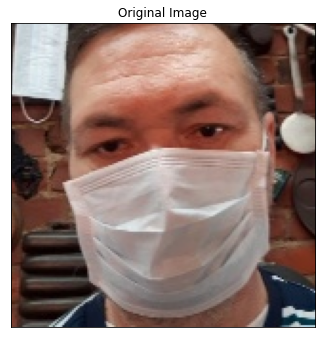

Model Random forest predicts that picture masks1032.jpg: Have a mask :).


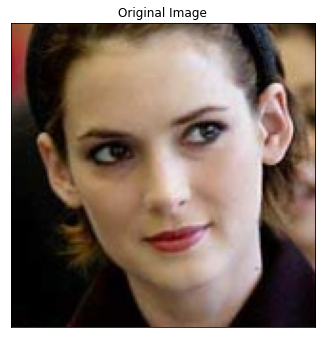

Model Random forest predicts that picture faces3030.jpg: Must wear a mask :(.


In [25]:
def predict_mask(model, picture_name, model_name):
    image = [hoc_feature(picture_name).flatten()]
    prediction = 'Have a mask :)' if model.predict(image)[0] else 'Must wear a mask :('
    print('Model {} predicts that picture {}: {}.'.format(model_name, picture_name,  prediction))
plot_images(load_image('masks1032.jpg'))
predict_mask(rand_f, 'masks1032.jpg', 'Random forest')
plot_images(load_image('faces3030.jpg'))
predict_mask(rand_f, 'faces3030.jpg', 'Random forest')

## Anomalies

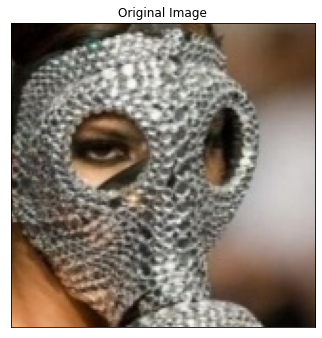

Model SVM predicts that picture anomalies/anom1.jpg: Have a mask :).
Model Random forest predicts that picture anomalies/anom1.jpg: Have a mask :).
Model Logistic regression predicts that picture anomalies/anom1.jpg: Have a mask :).


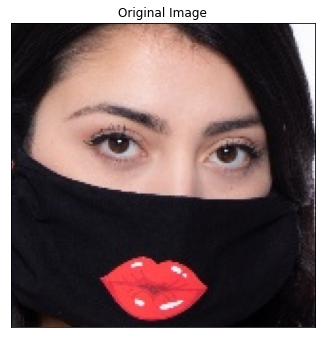

Model SVM predicts that picture anomalies/anom3.jpg: Have a mask :).
Model Random forest predicts that picture anomalies/anom3.jpg: Must wear a mask :(.
Model Logistic regression predicts that picture anomalies/anom3.jpg: Have a mask :).


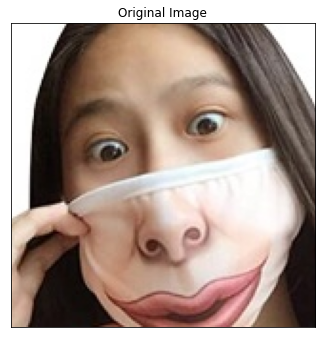

Model SVM predicts that picture anomalies/anom4.jpg: Have a mask :).
Model Random forest predicts that picture anomalies/anom4.jpg: Must wear a mask :(.
Model Logistic regression predicts that picture anomalies/anom4.jpg: Have a mask :).


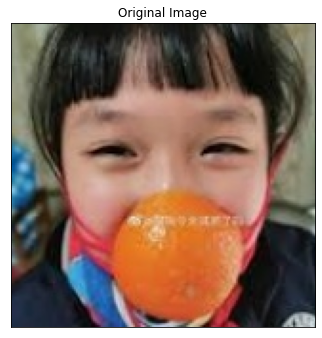

Model SVM predicts that picture anomalies/anom2.jpg: Have a mask :).
Model Random forest predicts that picture anomalies/anom2.jpg: Have a mask :).
Model Logistic regression predicts that picture anomalies/anom2.jpg: Have a mask :).


In [30]:
def evaluate_anomalies():
    anomalies_name = os.listdir(path + 'anomalies/')
    models = {"SVM": SVC(kernel="rbf", C=100), "Random forest": RandomForestClassifier(), "Logistic regression": LogisticRegression(solver='lbfgs', max_iter=100000)}
    for name in anomalies_name:
        image = load_image('anomalies/'+ name)
        plot_images(image)
        for model_name in models:
            models[model_name].fit(X, y)
            predict_mask(models[model_name], 'anomalies/'+name, model_name)
evaluate_anomalies()